In [1]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import random
import os
import copy
from pandas.core.common import flatten
import glob
import shutil
import cv2

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision.transforms import v2

c:\Users\24510\miniconda3\envs\Bert\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
os.chdir(os.getcwd())
os.listdir()

['.git',
 'ankylosaurus',
 'brontosaurus',
 'model_weights.pth',
 'pterodactyl',
 'README.md',
 'test.ipynb',
 'trex',
 'triceratops']

In [3]:
df = pd.DataFrame(columns=["Label", "Image"])
label = df["Label"].tolist()
image = df["Image"].tolist()

for folder in os.listdir():
    if not os.path.isfile(folder):
        for img in os.listdir(folder):
            image_path = os.getcwd() + "/" + folder + "/" + img
            label.append(folder)
            image.append(image_path)

df["Label"] = label
df["Image"] = image

In [4]:
df

,Label,Image
0,.git,d:\AI\DataHack/.git/config
1,.git,d:\AI\DataHack/.git/description
2,.git,d:\AI\DataHack/.git/HEAD
3,.git,d:\AI\DataHack/.git/hooks
4,.git,d:\AI\DataHack/.git/index
...,...,...
205,triceratops,d:\AI\DataHack/triceratops/5.png
206,triceratops,d:\AI\DataHack/triceratops/6.png
207,triceratops,d:\AI\DataHack/triceratops/7.png
208,triceratops,d:\AI\DataHack/triceratops/8.png


In [5]:
data = df.to_dict(orient='records')
data_dict = {}
for diction in data:
    if(diction["Label"] not in data_dict):
        data_dict[diction['Label']] = [diction['Image']]
    else:
        data_dict[diction['Label']].append(diction['Image'])

In [6]:
train_dict = copy.deepcopy(data_dict)
for key in train_dict:
    train_dict[key] = []
validation_dict = copy.deepcopy(train_dict)
test_dict = copy.deepcopy(train_dict)

for dino in data_dict:
    train_size = int(len(data_dict[dino]) * 0.75)
    validation_size = int((len(data_dict[dino]) - train_size) / 2)
    train_data = random.sample(data_dict[dino], train_size)

    remaining = [i for i in data_dict[dino] if i not in train_data]
    validation_data = random.sample(remaining, validation_size)
    test_data = [i for i in remaining if i not in validation_data]

    train_dict[dino] = train_data
    validation_dict[dino] = validation_data
    test_dict[dino] = test_data

In [7]:
os.makedirs("./train", exist_ok=True)
os.makedirs("./val", exist_ok=True)
os.makedirs("./test", exist_ok=True)

In [8]:
for cls in train_dict:
    os.makedirs(f"./train/{cls}", exist_ok=True)
    os.makedirs(f"./val/{cls}", exist_ok=True)
    os.makedirs(f"./test/{cls}", exist_ok=True)

for cls in train_dict:
    for img in train_dict[cls]:
        shutil.copy2(img, f"./train/{cls}/{os.path.basename(img)}")
    for img in validation_dict[cls]:
        shutil.copy2(img, f"./val/{cls}/{os.path.basename(img)}")
    for img in test_dict[cls]:
        shutil.copy2(img, f"./test/{cls}/{os.path.basename(img)}")

PermissionError: [Errno 13] Permission denied: 'd:\\AI\\DataHack/.git/objects'

In [ ]:
train_data_path = './train'
val_data_path = './val' 
test_data_path = './test'

train_image_paths = [] #to store image paths in list
classes = [] #to store class values

In [ ]:
# 1.Train
for data_path in glob.glob(train_data_path + '/*'):
    classes.append(data_path.split('/')[-1]) 
    train_image_paths.append(glob.glob(data_path + '/*'))
    
train_image_paths = list(flatten(train_image_paths))
random.shuffle(train_image_paths)

# 2.Val
val_image_paths = []
for data_path in glob.glob(val_data_path + '/*'):
    val_image_paths.append(glob.glob(data_path + '/*'))

val_image_paths = list(flatten(val_image_paths))
random.shuffle(val_image_paths)

# 3.Test
# create the test_image_paths
test_image_paths = []
for data_path in glob.glob(test_data_path + '/*'):
    test_image_paths.append(glob.glob(data_path + '/*'))

test_image_paths = list(flatten(test_image_paths))
random.shuffle(test_image_paths)

print("Train size: {}\nValid size: {}\nTest size: {}".format(len(train_image_paths), len(val_image_paths), len(test_image_paths)))

Train size: 150
Valid size: 25
Test size: 25


In [ ]:
idx_to_class = {i:j for i, j in enumerate(classes)}
class_to_idx = {value:key for key,value in idx_to_class.items()}

In [ ]:
idx_to_class

{0: 'train\\ankylosaurus',
 1: 'train\\brontosaurus',
 2: 'train\\pterodactyl',
 3: 'train\\trex',
 4: 'train\\triceratops'}

In [ ]:
transform_train = v2.Compose([
    v2.Resize((224, 224)),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomVerticalFlip(p=0.5),
    v2.RandomRotation(30),
    v2.RandomAffine(30),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

transform_test = v2.Compose([
    v2.Resize((224, 224)),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
class DinoDataset(Dataset):
    def __init__(self, image_paths, transform=False):
        self.image_paths = image_paths
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_filepath = self.image_paths[idx]
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = torch.from_numpy(image)
        label = "\\".join(image_filepath.split('\\')[:-1])
        label = label[2:]
        label = class_to_idx[label]
        if self.transform is not None:
            image = image.permute(2, 0, 1)
            image = self.transform(image)

        return image, label

train_dataset = DinoDataset(train_image_paths, transform_train)
val_dataset = DinoDataset(val_image_paths, transform_test)
test_dataset = DinoDataset(test_image_paths, transform_test)

In [ ]:
print('The shape of tensor for 50th image in train dataset: ', train_dataset[10][0].shape)
print('The label for 50th image in train dataset: ', train_dataset[10][1])

The shape of tensor for 50th image in train dataset:  torch.Size([3, 224, 224])
The label for 50th image in train dataset:  1


In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from pandas.core.common import flatten
import copy
import numpy as np
import random

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

import glob
from tqdm import tqdm

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

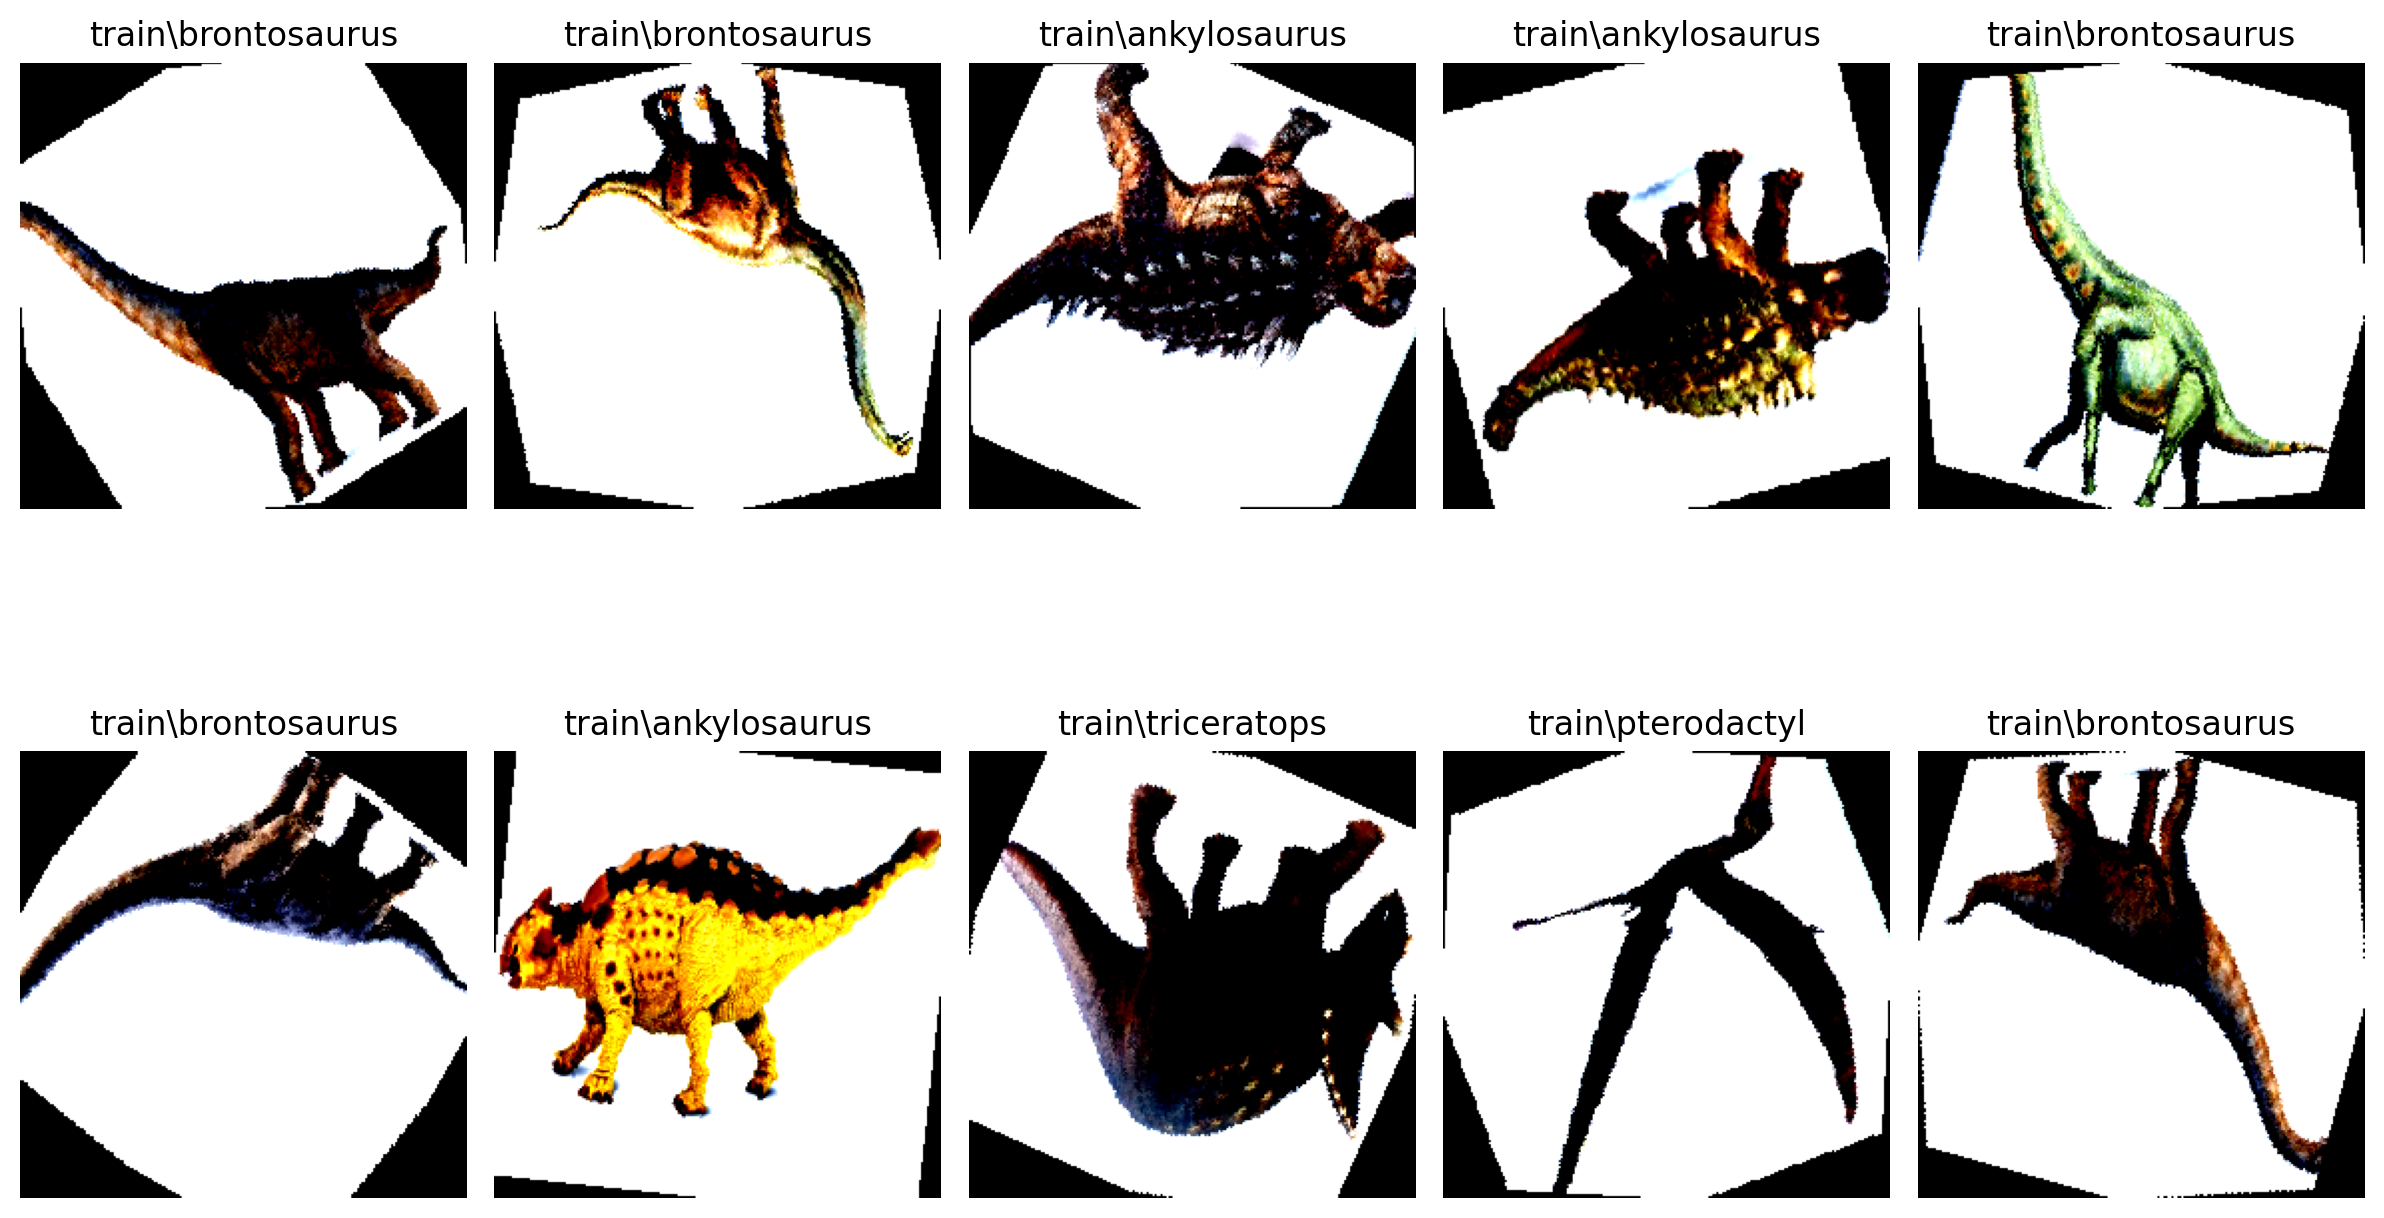

In [ ]:
import matplotlib.pyplot as plt

def visualize_augmentations(dataset, idx=0, samples=10, cols=5, random_img = False):
    
    dataset = copy.deepcopy(dataset)
    #we remove the normalize and tensor conversion from our augmentation pipeline
    # transformss = [t for t in dataset.transform if not isinstance(t, (A.Normalize, ToTensorV2))]
    # dataset.transform = A.Compose(transformss)
    rows = samples // cols
    
        
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 8))
    for i in range(samples):
        if random_img:
            idx = np.random.randint(1,len(train_image_paths))
        image, lab = dataset[idx]
        image = image.permute(1, 2, 0)
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_axis_off()
        ax.ravel()[i].set_title(idx_to_class[lab])
    plt.tight_layout(pad=1)
    plt.show()    

visualize_augmentations(train_dataset,np.random.randint(1,len(train_image_paths)), random_img = True)


In [ ]:
train_loader = DataLoader(
    train_dataset, batch_size=128, shuffle=True
)

valid_loader = DataLoader(
    val_dataset, batch_size=128, shuffle=True
)

test_loader = DataLoader(
    test_dataset, batch_size=128, shuffle=False
)

In [ ]:
# Check for GPU and CPU
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("No GPU available, using the CPU instead.")

Using GPU: NVIDIA GeForce RTX 4090 Laptop GPU


In [ ]:
model = models.efficientnet_b0(pretrained=True)
num_classes = 5  # replace with your number of classes
model.classifier = torch.nn.Linear(model.classifier[1].in_features, num_classes)
model = model.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

c:\Users\24510\miniconda3\envs\Bert\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\24510\miniconda3\envs\Bert\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
num_epochs = 100000
for epoch in range(num_epochs):
    model.train()
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if epoch % 200 == 0:
        torch.save(model.state_dict(), 'model_weights.pth')

    # Print loss every epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/100000], Loss: 0.6467
Epoch [2/100000], Loss: 0.2628
Epoch [3/100000], Loss: 0.0416
Epoch [4/100000], Loss: 0.0115
Epoch [5/100000], Loss: 0.2125
Epoch [6/100000], Loss: 0.0026
Epoch [7/100000], Loss: 0.0247
Epoch [8/100000], Loss: 0.0618
Epoch [9/100000], Loss: 0.0472
Epoch [10/100000], Loss: 0.3981
Epoch [11/100000], Loss: 0.0020
Epoch [12/100000], Loss: 1.0083
Epoch [13/100000], Loss: 0.0364
Epoch [14/100000], Loss: 1.1372
Epoch [15/100000], Loss: 0.5224
Epoch [16/100000], Loss: 0.2533
Epoch [17/100000], Loss: 0.1481
Epoch [18/100000], Loss: 0.3049
Epoch [19/100000], Loss: 0.1667
Epoch [20/100000], Loss: 0.1076
Epoch [21/100000], Loss: 0.0456
Epoch [22/100000], Loss: 0.2041
Epoch [23/100000], Loss: 0.0132
Epoch [24/100000], Loss: 0.2481
Epoch [25/100000], Loss: 0.1308
Epoch [26/100000], Loss: 0.1137
Epoch [27/100000], Loss: 0.1118
Epoch [28/100000], Loss: 0.0967
Epoch [29/100000], Loss: 0.0972
Epoch [30/100000], Loss: 0.0136
Epoch [31/100000], Loss: 0.0368
Epoch [32/100000]